#**3. gyakorlat - Mean-field terheléselosztásos rendszer, kiszolgálási idő eloszlása**

1. Tekintsünk egy terhelés-elosztási rendszert, amelyben 1 diszpécser és $N$ szerver van ($N$ nagy). A diszpécserhez érkező ráta $\lambda N$, ahol $\lambda=1.25$, a terhelés-elosztási elv JSQ. Az egyes szerverek buffermérete 5, a  kiszolgálási ráta a bufferben lévő igények (1, 2, 3, 4, 5) számától függően rendre $1.0, 1.1, 1.2, 1.3, 1.4$. A szerverek Processor Sharing (PS) kiszolgálást alkalmaznak, a kiszolgálási rátát egyenletesen osztják szét a bufferben lévő összes igény között. Kezdetben minden sor üres.

	(a) Írjuk fel az $N\to\infty$ limeszhez tartozó mean-field rendszerre vonatkozó differenciálegyenlet-rendszert.

  (b) Oldjuk meg a diffegyenlet-rendszert numerikusan Euler-módszerrel. Figyeljünk a szakadásokra!

	(c) Ábrázoljuk a megoldást a $[0,50]$ időtartamon.

  (d) Hogyan kaphatnánk meg a fentiekből numerikusan a mean-field stacionárius eloszlást?

  (e) Számítsuk ki Little-formula segítségével az átlagos kiszolgálási időt.

  (f) Mi a helyzet más terhelés esetén? Számítsuk ki a stacionárius eloszlást a következő terhelések esetén: $\lambda=0.5, \lambda=1.08, \lambda=1.35$. (A többi paraméter értéke változatlan.)



In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# (b)
def diffsolve_jsq(lmbd,mu,K,T,h=0.001):
    # lépésszám
    step = int(T/h)

    # kezdeti érték, inicializálás; v a teljes történelmet tárolja
    v=np.zeros([K+1,step])
    v[0,0]=1
    for i in range(1,K+1):
        v[i,0]=0
    i0 = 0; # legkisebb sorhossz

    # időpontok listáját inicializáljuk
    t=np.zeros(step)

    #iteráció
    i0 = 0; # legkisebb sorhossz
    for n in range(1,step):
        # minden i<i0-ra v[i]=0, és ez így is marad a következő lépésre is
        for i in range(i0):
            v[i,n] = 0
        lmbdu = mu[i0]*v[i0,n-1] #upkeep rátája
        lmbdd = lmbd - lmbdu # dynamic dispatch rátája
        # az i0 és i0+1 hosszú sorokra Euler-módszerrel számoljuk a következő lépést
        v[i0,n]=v[i0,n-1] + h*( -lmbdd + mu[i0+1]*v[i0+1,n-1])
        v[i0+1,n]=v[i0+1,n-1] + h*( lmbdd - mu[i0+1]*v[i0+1,n-1])
        # az (i0+1)-nél hosszabb sorokra nincs érkezés, csak kiszolgálás
        for i in range(i0+2,K):
            v[i,n]=v[i,n-1] + h*(mu[i+1]*v[i+1,n-1]-mu[i]*v[i,n-1])
        if i0<K-1:
            v[K,n]=v[K,n-1] + h*(-mu[K]*v[K,n-1])

        t[n]=t[n-1]+h # az időpontok listáját is frissítjük

        # ellenőrizzük, hogy volt-e szakadási pont, és ha igen, javítjuk
        if v[i0,n] < 0:
            h1 = h * v[i0,n-1]/(v[i0,n-1]-v[i0,n]);
            # ilyenkor csak h1 nagyságút lépünk
            v[i0,n]=v[i0,n-1] + h1*( -lmbdd + mu[i0+1]*v[i0+1,n-1])
            v[i0+1,n]=v[i0+1,n-1] + h1*( lmbdd - mu[i0+1]*v[i0+1,n-1])
            if i0 < K-1:
                v[K,n]=v[K,n-1] + h1*(-mu[K]*v[K,n-1])
            elif i0 == K-1:
                v[K,n]=v[K,n-1] + h1*(lmbdd-mu[K]*v[K,n-1])
            for i in range(i0+2,K):
                v[i,n]=v[i,n-1] + h1*(mu[i+1]*v[i+1,n-1]-mu[i]*v[i,n-1])
            t[n]=t[n-1] + h1
            # legkisebb sorhosszt frissítenünk kell
            # (üres rendszerből indulva csak nőhet, csökkenéssel nem kell foglalkoznunk)
            i0 = i0+1

    return v,t

def plotter(v,t):
    # több függvényt ábrázol egyszerre
    # v a függvényértékek táblázata, t a helyek listája
    plt.figure()
    for i in range(len(v)):
        plt.plot(t,v[i],label=str(i))
    plt.legend()
    plt.show()


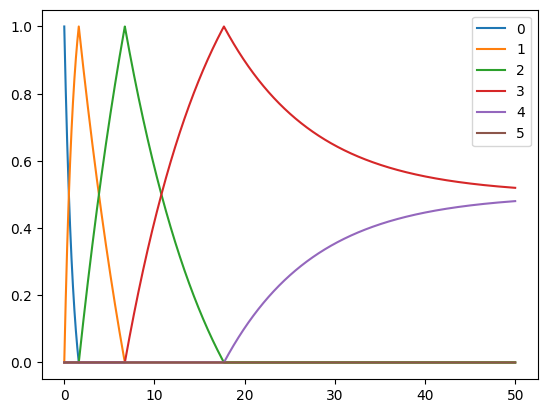

stacionárius eloszlás: [0.0, 0.0, 0.0, 0.5000000060074608, 0.49999999399254097, 0.0]
átlagos kiszolgálási idő: 2.7999999951940366
lambda= 0.5
stacionárius eloszlás: [0.5000000000000024, 0.4999999999999972, 0.0, 0.0, 0.0, 0.0]
lambda= 1.08
stacionárius eloszlás: [0.0, 0.20000000211755586, 0.7999999978824469, 0.0, 0.0, 0.0]
lambda= 1.35
stacionárius eloszlás: [0.0, 0.0, 0.0, 0.0, 0.500000008200142, 0.4999999917998567]


In [ ]:
# (c)
K=5
lmbd=1.25
mu=[0] + [0.9+0.1*i for i in range(1,K+1)]
T=50
v,t = diffsolve_jsq(lmbd,mu,K,T)
plotter(v,t)

# (d)
T=200 # gyakorlatilag T = végtelen
v,t = diffsolve_jsq(lmbd,mu,K,T,h=0.01) # hogy gyorsabb legyen, a lépésközt durvábbra vesszük
vst= [v[i,-1] for i in range(K+1)]
print('stacionárius eloszlás:',vst)

# (e)
L=np.dot(vst,range(K+1))
W=L/lmbd
print('átlagos kiszolgálási idő:',W)

# (f)
lmbdlist = [0.5, 1.08, 1.35]
for lmbd in lmbdlist:
    v,t = diffsolve_jsq(lmbd,mu,K,T,h=0.01)
    vst= [v[i,-1] for i in range(K+1)]
    print('lambda=',lmbd)
    print('stacionárius eloszlás:',vst)


2. Az előző feladatbeli terheléselosztó rendszert vizsgáljuk, a paraméterek ugyanazok.

  (a) Határozzuk meg analitikusan a stacionárius eloszlást.

	(b) Legyen $f_i(t)$ egy olyan igény kiszolgálási idejének a sűrűségfüggvénye, amelyik egy $i$ hosszú sorban áll éppen. Számítsuk ki a Laplace-transzformáltját.

	(c) Számítsuk ki és ábrázoljuk egy véletlen igény kiszolgálási idejének eloszlásfüggvényét.


<IPython.core.display.Math object>

0.500000000000000

<IPython.core.display.Math object>

0.500000000000000

<IPython.core.display.Math object>

0.600000000000000

<IPython.core.display.Math object>

(40.0*s + 117.0)/(100.0*s**2 + 370.0*s + 117.0)

<IPython.core.display.Math object>

(40.0*s + 117.0)/(100.0*s**2 + 370.0*s + 117.0)

<IPython.core.display.Math object>

6.5*(5.0*s + 18.0)/(100.0*s**2 + 370.0*s + 117.0)

<IPython.core.display.Math object>

0.1*(-9.92115644327973*exp(-1.85*t)*sinh(1.50083310198036*t) - 10.0*exp(-1.85*t)*cosh(1.50083310198036*t))*Heaviside(t) + 1.0*Heaviside(t)

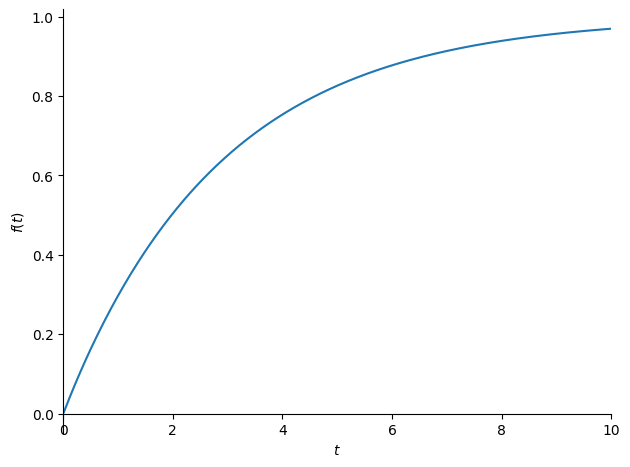

In [ ]:
import numpy as np
import sympy as sp # csomag szimbolikus (analitikus) számításokhoz
from IPython.display import display, Math # matematikai függvényeket szépen formázva ír ki

# rendszer paraméterek
K=5
mu=[0 ] + [0.9+0.1*i for i in range(1,K+1)]
lmbd=1.25

# előkészület: a stacionárius eloszlásban csak kétféle sorhossz van, i_0 és i_0+1; kiszámítjuk i_0 értékét
i0=np.where(np.array(mu)<lmbd)[0][-1]

# ismeretlenek listája; ennek két szerepe van:
# egyrészt deklaráljuk, hogy ezek változó szimbólumok, amiket az egyenletek analitikus megoldásánál használhat,
# másrészt ha a szimbólumok egyúttal latex képletek is, akkor majd meg is tudjuk szépen jeleníteni
xi0, xi0p1 = sp.symbols('x_{i_0}, x_{i_0+1}') # a stacionárius eloszlás
lmbdd, mui0, mui0p1, s, t = sp.symbols('\lambda_d, \mu_{i_0}, \mu_{i_0+1}, s,  t')
Fs, fi0m1s, fi0s, fi0p1s = sp.symbols('F^*(s), f^*_{i_0-1}(s), f^*_{i_0}(s), f^*_{i_0+1}(s)')
fi0m1t, fi0t, fi0p1t = sp.symbols('f_{i_0-1}(t), f_{i_0}(t), f_{i_0+1}(t)')

# a következőkben felírjuk a nekünk szükséges egyenleteket
# jelentős részét meg is lehetne oldani kézzel, de dolgozzon inkább a python

# stacionárius eloszlás egyenletei
eqxi0 = xi0*mui0 + xi0p1*mui0p1 - lmbd
eqxi0p1 = xi0 + xi0p1 - 1

# i0 és i0+1-hez tartozó kiszolgálási ráták, lambda_d
eqmui0 = mui0 - mu[i0]
eqmui0p1 = mui0p1 - mu[i0+1]
eqlmbdd = xi0*mui0 - lmbdd

# fő LT egyenletek
eq1 = fi0s - fi0m1s
eq2 = 1/ (lmbdd/xi0 + mui0 + s) * (lmbdd/xi0* fi0p1s + (i0-1)/i0 * mui0  * fi0p1s + 1/i0 * mui0) - fi0s
eq3 = i0/(i0+1) * mui0p1 / (mui0p1 + s) * fi0s + 1/(i0+1) * mui0p1 / (mui0p1 + s) - fi0p1s

# eredő F*(s) függvény
eqFs = - Fs + (lmbdd/lmbd * fi0s + (lmbd-lmbdd)/lmbd * fi0p1s)/s

allvars = [xi0, xi0p1, lmbdd, fi0m1s, fi0s, fi0p1s, Fs, mui0, mui0p1] #
basicvars = [xi0, xi0p1, lmbdd] #
funs = [fi0m1s, fi0s, fi0p1s] #
sol = sp.solve([eqmui0,eqmui0p1,eqxi0, eqxi0p1, eqlmbdd], basicvars, dict = True)[0] #
sol = sp.solve([eqxi0, eqxi0p1, eqlmbdd, eqmui0, eqmui0p1, eq1, eq2, eq3, eqFs], allvars, dict = True)[0] #

for i, var in enumerate(basicvars):
    display(Math(str(var)+'='))
    display(sol[var])
    print("\n")

for i, var in enumerate(funs):
    display(Math(str(var)+'='))
    display(sol[var])
    print("\n")

Ft= sp.inverse_laplace_transform(sol[Fs], s, t) # behelyettesítjük a paramétereket
display(Math('F(t)='))
display(Ft)
print("\n")
sp.plot(Ft, xlim=[0,10], show=True, label='F(t)')



3. Tekintsünk egy terhelés-elosztási rendszert, ahol egy diszpécser és $N$ szerver van, és a diszpécser Join-Below-Threshold (JBT) terheléselosztási elvet követ: ilyenkor minden szerverhez meg van adva egy $B$ küszöb, és a diszpécser azon szerverek közül választ találomra, amelyeknél a sorhossz a küszöb alatt van (illetve ha minden szerver sorhossza eléri a küszöböt, akkor az összes szerver közül választ találomra).

  Az egyes szerverek buffermérete 5, a kiszolgálási ráta a bufferben lévő igények (1, 2, 3, 4, 5) számától függően rendre $1.0, 1.1, 1.2, 1.3, 1.4$. A szerverek Processor Sharing (PS) kiszolgálást alkalmaznak, a kiszolgálási rátát egyenletesen osztják szét a bufferben lévő összes igény között. Kezdetben minden sor üres.

  A diszpécserhez történő érkezések rátája $\lambda N$, ahol $\lambda=1.25$, és a szerverek telítettségi küszöbe $B=4$.

	(a) Írjuk fel az $N\to\infty$ limeszhez tartozó mean-field rendszerre vonatkozó differenciálegyenlet-rendszert.

  (b) Oldjuk meg a diffegyenlet-rendszert numerikusan Euler-módszerrel.

	(c) Ábrázoljuk a megoldást a $[0,50]$ időtartamon.

  (d) Számítsuk ki numerikusan a mean-field stacionárius eloszlást.

  (e) Little-formula segítségével számítsuk ki egy véletlen igény átlagos kiszolgálási idejét ($W$).

  (f) Vizsgáljuk meg, hogyan változik $W$ a terheléstől és a küszöb értékétől függően.



In [ ]:
import numpy as np

def diffsolve_jbt(lmbd,mu,K,B,T,vinit=0,h=0.001):
    # lépésszám
    step = int(T/h)

    # kezdeti érték
    v=np.zeros([K+1,step])
    if vinit == 0:  # az alapértelmezés az üres rendszer
        vinit = np.zeros(K+1)
        vinit[0]=1
        for i in range(1,K+1):
            vinit[i]=0
    # inicializálás; v a teljes történelmet letárolja
    for i in range(0,K+1):
        v[i,0]=vinit[i]
    free = 1; # 1, ha van küszöb alatti (szabad) szerver, 0 ha nincs

    # időpontok listáját inicializáljuk
    t=np.zeros(step)

    #iteráció
    for n in range(1,step):
        if free == 1: # ha van szabad szerver
            x=sum([v[i,n-1] for i in range(B)]) # a szabad szerverek között egyenletesen oszlik el a terhelés
            v[0,n]=v[0,n-1] + h*( - lmbd*v[0,n-1]/x + mu[1]*v[1,n-1])
            for i in range(1,B):
                v[i,n]=v[i,n-1] + h*( - lmbd*v[i,n-1]/x + lmbd*v[i-1,n-1]/x - mu[i]*v[i,n-1] + mu[i+1]*v[i+1,n-1])

            # a B-nél hosszabb sorokba nem érkezik terhelés kívülről, és kisebb sorok sem hízhatnak fel addig, viszont hosszabb sorok lefogyhatnak addig
            for i in range(B+1,K):
                v[i,n]=v[i,n-1] + h*( - mu[i]*v[i,n-1] + mu[i+1]*v[i+1,n-1])

            # a K hosszú soroknál nincs hosszabb sor, ami lefogyhatna addig
            v[K,n]=v[K,n-1] + h*(- mu[K]*v[K,n-1])

            # az éppen B hosszú sorokba nem érkezik terhelés kívülről, de rövidebb sorok még felhízhatnak addig, és hosszabb sorok is lefogyhatnak addig
            if B<K:
                v[B,n]=v[B,n-1] + h*( lmbd*v[B-1,n-1]/x - mu[B]*v[B,n-1] + mu[B+1]*v[B+1,n-1])
            # kivéve, ha B=K, mert akkor hosszabb sorok nincsenek
            elif B==K:
                v[B,n]=v[B,n-1] + h*( lmbd*v[B-1,n-1]/x - mu[B]*v[B,n-1])


            t[n]=t[n-1]+h
        elif free == 0: # ha nincs szabad sor
            for i in range(B):
                v[i,n]=v[i,n-1] # a legfeljebb B-1 hosszú sorok aránya eleve 0, az is marad

            # a beérkező rátából lambda_u az upkeep, ez a B hosszú sorok fenntartására fordítódik
            lmbdu = mu[B]*v[B,n-1]
            # csak a maradék lambda_d ráta oszlik el a sorok között egyenletesen
            lmbdd = lmbd - lmbdu

            v[B,n]=v[B,n-1] + h*( -lmbdd*v[B,n-1] + mu[B+1]*v[B+1,n-1])

            for i in range(B+1,K-1):
                v[i,n]=v[i,n-1] + h*( - lmbdd*v[i,n-1] + lmbdd*v[i-1,n-1] - mu[i]*v[i,n-1] + mu[i+1]*v[i+1,n-1])

            v[K-1,n]=v[K-1,n-1] + h*( - lmbdd*v[i,n-1] + lmbdd*v[i-1,n-1] - mu[i]*v[i,n-1] + mu[i+1]*v[i+1,n-1])


            v[0,n]=v[0,n-1] + 0
            v[1,n] = v[1,n-1] + h*( - (lmbd-mu[1]*v[1,n-1])*v[1,n-1] + mu[2]*v[2,n-1])
            for i in range(2,K-1):
                v[i,n] = v[i,n-1] + h*((lmbd-mu[1]*v[1,n-1])*v[i-1,n-1] - (lmbd-mu[1]*v[1,n-1])*v[i,n-1] + mu[i+1]*v[i+1,n-1] - mu[i]*v[i,n-1])
            v[K-1,n]=v[K-1,n-1] + h*((lmbd-mu[1]*v[1,n-1])*v[K-2,n-1]-mu[K-1]*v[K-1,n-1])

            t[n]=t[n-1]+h


        if min([v[i,n] for i in range(B)]) < 0:
            h0 = h * v[0,n-1]/(v[0,n-1]-v[0,n])
            for i in range(B):
                v[i,n] = 0

            v[B,n]=1

            for i in range(B+1,K):
                v[i,n] = 0

            t[n]=t[n-1]+h0
            free = 1;



    return v,t

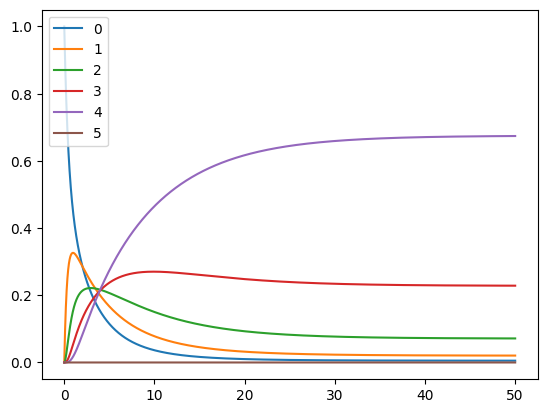

stacionárius eloszlás: [0.005282921781667966, 0.02033010549503921, 0.07112338184347196, 0.22808493667587842, 0.6751786542039406, 0.0]


In [ ]:
K=5
B=4
lmbd=1.25
mu=[0] + [0.9+0.1*i for i in range(1,K+1)]
T=50

# (c)
v,t = diffsolve_jbt(lmbd,mu,K,B,T)
plotter(v,t)

# (d)
v,t = diffsolve_jbt(lmbd,mu,K,B,200,h=0.01)
vst= [v[i,-1] for i in range(K+1)]
print('stacionárius eloszlás:',vst)


In [ ]:
# (f)
import numpy as np
lmbdlist=[0.7, 1.05, 1.25, 1.35]
K=5
mu=[0] + [0.9+0.1*i for i in range(1,K+1)]


for lmbd in lmbdlist:
    Bmin=np.where(np.array(mu)>lmbd)[0][0]
    for B in range(Bmin,K):
        v,t = diffsolve_jbt(lmbd,mu,K,B,200,h=0.01)
        vst= [v[i,-1] for i in range(K+1)]
        L=np.dot(vst,range(K+1))
        W=L/lmbd
        print('lambda=',lmbd,'B:',B,'W=',W)


lambda= 0.7 B: 1 W= 0.9999999999999921
lambda= 0.7 B: 2 W= 1.4161200459500396
lambda= 0.7 B: 3 W= 1.6533070904681535
lambda= 0.7 B: 4 W= 1.7921448666100388
lambda= 1.05 B: 2 W= 1.690092998138902
lambda= 1.05 B: 3 W= 2.0760810155602134
lambda= 1.05 B: 4 W= 2.3340361399679175
lambda= 1.25 B: 4 W= 2.8380370368203045


 4. Az előző feladathoz hasonlóan JBT rendszert vizsgálunk.

 (a) Az egyes szerverek buffermérete $K=3$, a küszöb $B=3$, a kiszolgálási ráta a bufferben lévő igények (1, 2, 3) számától függően rendre $3.0, 0.8, 1.003$, a rendszer terhelése $\lambda=1.0$. Indítsuk el a mean-field rendszert a $[0, 0, 0.1, 0.9]$ kezdeti feltételből. Ábrázoljuk a rendszer fejlődését.

 (b) Mit tapasztalunk, ha ugyanezt a rendszert a $[0.15, 0.10, 0.25, 0.50]$ kezdeti feltételből indítjuk el?

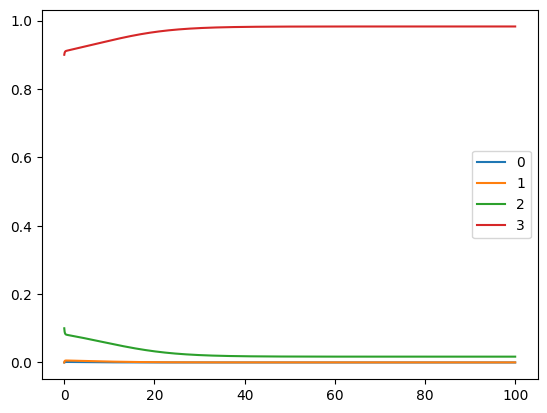

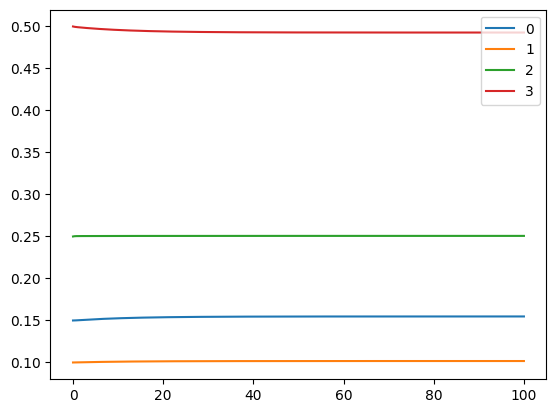

In [ ]:
K=3
B=3
mu=[0, 3.0, 0.8, 1.003]
lmbd=1
T=100

vinit = [0, 0, 0.1, 0.9]
v,t = diffsolve_jbt(lmbd,mu,K,B,T,vinit,h=0.01)
plotter(v,t)

vinit = [0.15, 0.10, 0.25, 0.5]
v,t = diffsolve_jbt(lmbd,mu,K,B,T,vinit,h=0.01)
plotter(v,t)

